In [ ]:
"""

Author: Harshil Neeraj

Calculating Wigner function in DKC

"""
"""
This code uses the gpe1d module written by Shreyas Potnis (https://github.com/shreyaspotnis/gpe1d). 
I am using it in the limit of no interactions to solve the time-dependent Schrodinger equation.
"""


import os
import datetime
import numpy as np
from gpe1d import gpe1d_python
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy.fft as fft
from scipy.optimize import curve_fit
from scipy.constants import pi, hbar
import scipy.integrate as integrate
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d

def Prob(psi):
    return np.real(psi*np.conj(psi)) # return |psi|^2

def expectation_value(x,psi,f): # expectation value of any function f(x)
    dx = x[1]-x[0]
    return dx*np.sum(np.multiply(f,psi*np.conjugate(psi)))

def expectation_value_ab(x,psi,f,a,b): # expectation value of any function f(x) within limits (a,b) (So, integral f(x) X psi*(x) X psi(x))
    dx = x[1]-x[0]
    sum = 0
    N = np.size(x)
    for i in range(N):
        if x[i]>=a and x[i]<=b:
            sum = sum + dx*np.multiply(f,psi*np.conjugate(psi))
        if x[i]>b:
            break
    return np.sum(sum)

def func3(K,a,b,c): # gaussian fitting function y = a*exp(-((K-K0)**2)/(4*b**2))+c
    return (a*np.exp(-(K**2)/(4*b*b))) + c

def area(x,y,a,b): # find the integral of function y(x) within limits (a,b)
    sum = 0
    N = np.size(x)
    dx = x[1]-x[0]
    for i in range(N):
        if x[i]>=a and x[i]<=b:
            sum = sum + dx*y[i]
        if x[i]>b:
            break
    return sum

def area_total(x,y): # find the integral of function y(x) from x_min to x_max
    sum = 0
    N = np.size(x)
    dx = x[1]-x[0]
    for i in range(N):
        sum = sum + dx*y[i]
    return sum

def integrate_1d(x,f):
    return integrate.trapz(f, x)

def integrate_2d(x,y,f): # 2D integral \int \int dx dy f(x,y)
    return integrate.trapz(integrate.trapz(f, y), x)

def Wigner_fn(X, K, psi):
    N_x = len(psi)
    W = np.zeros([N_x, N_x], dtype=np.complex128)
    dx = X[1] - X[0]
    XS_matrix = np.zeros([N_x, N_x], dtype=np.complex128)
    SK_matrix = np.zeros([N_x, N_x], dtype=np.complex128)
    S_vals = np.concatenate((X[N_x//2:], X[:N_x//2]))
    for i in range(N_x):
        for j in range(N_x//2):
            if 0 <= i-j <=N_x and 0 <= i+j < N_x:
                XS_matrix[i,j] = np.conj(psi[i-j]) * psi[i+j]
        for j in range(N_x//2):
            XS_matrix[i,j + N_x//2 + 1] = np.conj(XS_matrix[i, N_x//2 - j])
    S = S_vals.reshape(-1, 1)
    K = K.reshape(1, -1)
    SK_matrix = np.exp(-2j * np.matmul(S,K))
    W = (1/pi) * dx * np.matmul(XS_matrix,SK_matrix)
    return np.transpose(np.real(W)) 


"""Example to see why transpose is needed at the end of wigner function code"""
"""
x = np.linspace(0,10,11)
y = np.linspace(-5,5,11)

X, Y = np.meshgrid(x, y)

Z = X + Y**3
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X,Y,Z,11)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

print(Z)

z_loop = np.zeros([11,11])

for i in range(11):
    for j in range(11):
        z_loop[i][j] = x[i] + y[j]**3

print(z_loop)

d = "True " if np.array_equal(Z,z_loop) else "False"
print("True " if np.array_equal(Z,z_loop) else "False")
print ("True " if np.array_equal(Z,np.transpose(z_loop)) else "False")
"""



'\nx = np.linspace(0,10,11)\ny = np.linspace(-5,5,11)\n\nX, Y = np.meshgrid(x, y)\n\nZ = X + Y**3\nfig,ax=plt.subplots(1,1)\ncp = ax.contourf(X,Y,Z,11)\nfig.colorbar(cp) # Add a colorbar to a plot\nax.set_xlabel(\'x\')\nax.set_ylabel(\'y\')\nplt.show()\n\nprint(Z)\n\nz_loop = np.zeros([11,11])\n\nfor i in range(11):\n    for j in range(11):\n        z_loop[i][j] = x[i] + y[j]**3\n\nprint(z_loop)\n\nd = "True " if np.array_equal(Z,z_loop) else "False"\nprint("True " if np.array_equal(Z,z_loop) else "False")\nprint ("True " if np.array_equal(Z,np.transpose(z_loop)) else "False")\n'

In [2]:
# Use full LaTeX rendering
plt.rcParams['text.usetex'] = True

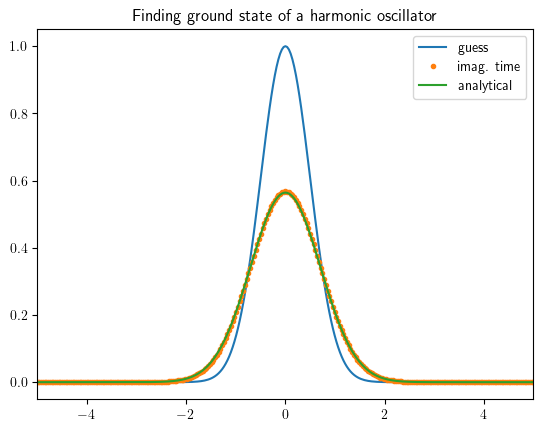

In [3]:
# Using typical parameters in cold atom experiments
mass = 1.4e-25      # Mass of 87Rb
omega = 2.0*pi*150  # 150 Hz trapping frequency. This is for the trap in which we condense the atoms.

length_scale = (hbar/mass/omega)**0.5
time_scale = 1.0/omega
energy_scale = hbar*omega

velocity_scale = length_scale/time_scale

kB = 1.380649e-23 # Boltzmann constant

# we shall work in units of the harmonic oscillator strength

N_x = 5001 # number of points in which x- space is divided
# N_x = 1001

L_x = (N_x-1)*np.sqrt(pi/(2*N_x))
X = np.linspace(-L_x,L_x, N_x)


dx = X[1] - X[0]
U_trap = 0.5*X**2 # trap potential (harmonic)
U_free = 0 # free evolution --- U = 0

psi_guess = np.exp(-X**2)
psi_analytical = (pi)**-0.25*np.exp(-X**2/2.0)

# normalize it
# Take kappa = 0, epsilon = 1 for GPE to reduce to the Schrodinger equation
# Take imaginary time to find the ground state -- Ref: https://www.algorithm-archive.org/contents/split-operator_method/split-operator_method.html
# https://www.youtube.com/watch?v=BBt8EugN03Q 

k = 0.001

(K, T, psi_ground, ep) = gpe1d_python(epsilon=1.0, kappa=0.0, N=5000, 
                            k=0.001, X=X, U=U_trap, psi0=psi_guess, Ntstore=11, 
                            imag_time=1, error=0.0001)   


# (K, T, psi_ground, ep) = gpe1d_python(epsilon=1.0, kappa=0.0, N=40000, 
#                             k=0.001/10, X=X, U=U_trap, psi0=psi_guess, Ntstore=11, 
#                             imag_time=1, error=0.0002/3)   

# Plot the ground state of the wavefunction

plt.title('Finding ground state of a harmonic oscillator')
plt.plot(X, Prob(psi_guess))
plt.plot(X, Prob(psi_ground),'.')
plt.plot(X, Prob(psi_analytical))
plt.legend(['guess', 'imag. time', 'analytical'])
plt.xlim(-5,5)
plt.show()


In [4]:
# print("L = ", L)
print("N_x = ", N_x)
print("Time scale = ",1000*time_scale, "ms")
print("Energy scale = ",energy_scale*1e9/kB, "nK")
print("Length scale = ",length_scale*1e6, "um")
print("Length scale/sqrt(2) = ",length_scale*1e6/np.sqrt(2), " um")

N_x =  5001
Time scale =  1.061032953945969 ms
Energy scale =  7.1988646100493305 nK
Length scale =  0.8940020177451148 um
Length scale/sqrt(2) =  0.6321548891420268  um


In [5]:
sigma_wavefunction_ground = np.real(np.sqrt(expectation_value(X,psi_ground,X**2)-(expectation_value(X,psi_ground,X)**2))) # spread of the initial wave packet
sigma_k_ground = 1/(2*sigma_wavefunction_ground)
print("Spread of the initial wave function = ",sigma_wavefunction_ground)
print("Spread of k-space wavefunction = ", 1/(2*sigma_wavefunction_ground), " = ", velocity_scale*1e3*1/(2*sigma_wavefunction_ground), " mm/s")
print("Ground state x-space spread of wave function", sigma_wavefunction_ground*length_scale*1e6," um")


"""Check if numerically calc psi is normalised or not"""

print(integrate_1d(X,np.abs(psi_ground)**2))

Spread of the initial wave function =  0.7028027979016422
Spread of k-space wavefunction =  0.7114371221811433  =  0.5994405926445036  mm/s
Ground state x-space spread of wave function 0.6283071194009803  um
0.9999999999999525


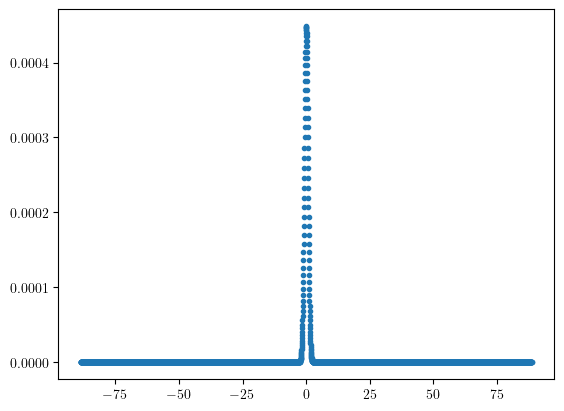

dk =  0.03544553264205437
k_max =  88.61383160513593
L_x =  88.61383160514013
dx =  0.03544553264205774


In [6]:
""""Small code just to check how good resolution in k-space is"""
ft = (2/np.size(K))*np.abs(fft.fft(psi_ground)) # FFT
plt.plot(K,Prob(ft),'.')
# plt.xlim(-0.3,3)
plt.show()
print("dk = ",K[1]-K[0])
print("k_max = ",max(K))
print("L_x = ", L_x)

print("dx = ",dx)



In [7]:
""" K currently doesn't have values stored in ascending order, and so we sort the array"""

print("K (before rearranging values = )", K)

print("now doing the rearrangement: ")
# K = np.concatenate((K[N_x//2:], K[:N_x//2]))
K = np.fft.fftshift(K)
dk = K[1]-K[0]
print("dk = ",dk)
print("K = ", K)



K (before rearranging values = ) [ 0.          0.03544553  0.07089107 ... -0.1063366  -0.07089107
 -0.03544553]
now doing the rearrangement: 
dk =  0.03544553264205774
K =  [-88.61383161 -88.57838607 -88.54294054 ...  88.54294054  88.57838607
  88.61383161]


In [8]:
K2 = K # extra variable to store the K values
print("K2 = ",K2)

K2 =  [-88.61383161 -88.57838607 -88.54294054 ...  88.54294054  88.57838607
  88.61383161]


In [9]:
"""Select location of the folder for saving the plots"""

# Get the current date and time
now = datetime.datetime.now()

# Format the date as a string (e.g., "2024-07-15")
date_str = now.strftime("%Y-%m-%d")

print(date_str)


# Define the directory and filename
directory = "/Users/harshilneeraj/Library/CloudStorage/OneDrive-UniversityofToronto/Research/Codes/gpe1d/examples/DKC,"+date_str  # Replace with your desired directory
# filename = 'Momentum width after a Gaussian (sigma = %5.0f Delta x_i) and a Harmonic delta-kick.pdf' % (sigma_a / sigma_wavefunction_ground)
# save_path = os.path.join(directory, filename)

# Create the directory if it doesn't exist
os.makedirs(directory, exist_ok=True)


2025-05-13


In [10]:
"""Calculating the wigner function in the ground state of the trap"""

W_ground = Wigner_fn(X,K,psi_ground)

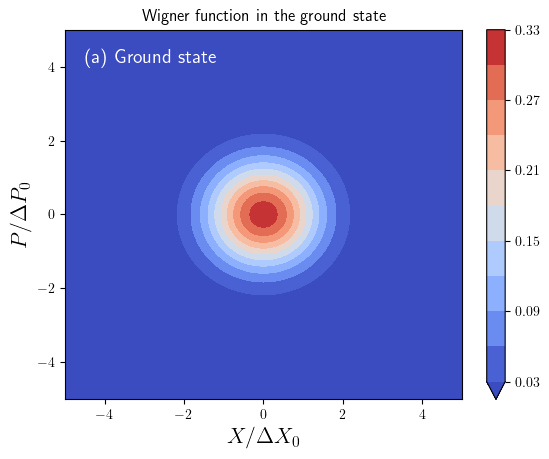

In [ ]:
Xm, Km = np.meshgrid(X, K)
fig,ax=plt.subplots(1,1)
cp = ax.contourf(Xm/sigma_wavefunction_ground,Km/sigma_k_ground,W_ground, 100, extend = 'min',cmap = cm.coolwarm)
fig.colorbar(cp) # Add a colorbar to a plot
# cp1 = ax.contour(Xm/sigma_wavefunction_ground,Km/sigma_k_ground,W_ground,5, extend = 'min',cmap = 'Reds')
ax.set_title('Wigner function in the ground state')
ax.text(0.05, 0.95, '(a) Ground state', transform=ax.transAxes, fontsize=14, verticalalignment='top', color = 'white')
ax.set_xlabel('$X/\Delta X_{0}$', fontsize = 16)
ax.set_ylabel('$P/\Delta P_{0}$', fontsize = 16)
plt.xlim(-5,5)
plt.ylim(-5,5)
# plt.savefig('Wigner function in the ground state.pdf')
# plt.xlim(-20,20)
# plt.ylim(-20,20)
plt.show()

In [10]:
# print(type(W_ground))
# print(W_ground.ndim)

# if np.any(W_ground < 0):
#     print("W_ground contains values less than 0.")
# else:
#     print("W_ground does not contain any values less than 0.")


# # # Assuming W_ground is your 2D numpy array
# # indices = np.where(W_ground < 0)

# # # Get the values at those indices
# # negative_values = W_ground[indices]

# # # Print the values and their locations
# # for value, (i, j) in zip(negative_values, zip(*indices)):
# #     print(f"Value: {value}, Location: ({i}, {j})")


# # Define the limits for x and k
# x_min, x_max = -25, 25  # Example limits for x
# k_min, k_max = -25, 25  # Example limits for k1

# # Find the indices where Xm and Km fall within the specified limits
# x_indices = np.where((X >= x_min) & (X <= x_max))
# k_indices = np.where((K >= k_min) & (K <= k_max))


# # Combine the indices to get the range of interest in W_ground
# combined_indices = (x_indices, k_indices)

# # Check for values less than 0 in the specified range
# negative_indices = np.where(W_ground[combined_indices] < 0)

# print(negative_indices)

# # Extract the values and their actual positions
# negative_values = W_ground[combined_indices][negative_indices]

# # Adjust the indices to the original array dimensions
# actual_indices = (combined_indices[0][negative_indices[0]], combined_indices[1][negative_indices[1]])

# # Print the values and their locations
# for value, (i, j) in zip(negative_values, zip(*actual_indices)):
#     print(f"Value: {value}, Location: ({i}, {j})")





In [12]:
k = 0.001
sigma_a = 5*sigma_wavefunction_ground
N_f = 1500
# N_f = 2000

n_alpha = 50
# alpha_start = 1.25
# alpha_end = 1.4
alpha_start = 0.75
alpha_end = 1
# alpha_opt = 0.9
alpha = np.linspace(alpha_start,alpha_end,n_alpha)

X_m_plot = 10
K_m_plot = 10


W_free calculated______________
_____________________________
W_harmonic calculated______________
_____________________________
Free expansion time =  1.5
alpha[ 0 ] =  0.75
alpha[ 1 ] =  0.7551020408163265
alpha[ 2 ] =  0.7602040816326531
alpha[ 3 ] =  0.7653061224489796
alpha[ 4 ] =  0.7704081632653061
alpha[ 5 ] =  0.7755102040816326
alpha[ 6 ] =  0.7806122448979592
alpha[ 7 ] =  0.7857142857142857
alpha[ 8 ] =  0.7908163265306123
alpha[ 9 ] =  0.7959183673469388
alpha[ 10 ] =  0.8010204081632653
alpha[ 11 ] =  0.8061224489795918
alpha[ 12 ] =  0.8112244897959183
alpha[ 13 ] =  0.8163265306122449
alpha[ 14 ] =  0.8214285714285714
alpha[ 15 ] =  0.826530612244898
alpha[ 16 ] =  0.8316326530612245
alpha[ 17 ] =  0.8367346938775511
alpha[ 18 ] =  0.8418367346938775
alpha[ 19 ] =  0.846938775510204
alpha[ 20 ] =  0.8520408163265306
alpha[ 21 ] =  0.8571428571428571
alpha[ 22 ] =  0.8622448979591837
alpha[ 23 ] =  0.8673469387755102
alpha[ 24 ] =  0.8724489795918368
alpha[ 25 ] =  0.8775

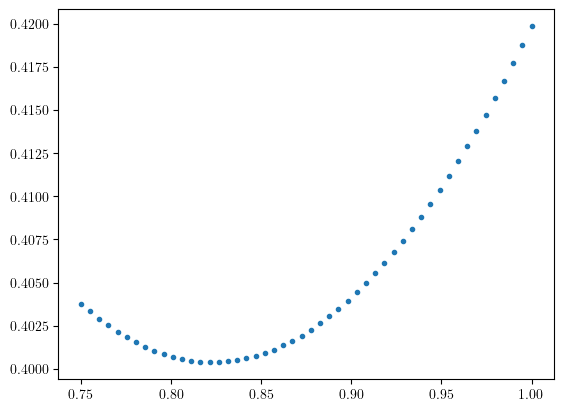

index of alpha_opt =  14
alpha_ opt =  0.8214285714285714
sigma_k at alpha_opt =  0.4003929898117893
sigma_k at alpha_opt/sigma_k_ground =  0.5627946269998585
W_1_Gaussian_DKC calculated______________
_____________________________
[5. 4.]
W_2_Gaussian_DKC calculated______________
_____________________________
[5. 4. 3.]
W_3_Gaussian_DKC calculated______________
_____________________________


In [13]:
# N_f = 14000
# N_f = 7000
# N_f = 7818
# N_f = 8040.4
# N_f = 3000

"""Wigner function after free evolution"""

psi_after_free_evolution = ((sigma_wavefunction_ground*sigma_wavefunction_ground/(2*pi*(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f*k*0.5)**2))**0.25)*np.exp(-0.25*X*X/(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f*k*0.5))
sigma_wavefunction_after_free_expansion = np.real(np.sqrt(expectation_value(X,psi_after_free_evolution,X**2)-(expectation_value(X,psi_after_free_evolution,X)**2))) # spread of the wave packet just before delta kick (after free expansion)
W_after_free_evolution = Wigner_fn(X,K,psi_after_free_evolution)    

print("W_free calculated______________")
print("_____________________________")

"""Harmonic dkc"""
omega_dimensionless = 1
kick_str_harmonic = omega_dimensionless**2 * N_f * k/(1 + (omega_dimensionless * N_f * k)**2)
psi_after_harmonic_kick = psi_after_free_evolution*np.exp(-1j *kick_str_harmonic *X*X/(2))
W_after_harmonic_kick = Wigner_fn(X,K,psi_after_harmonic_kick)

print("W_harmonic calculated______________")
print("_____________________________")


"""1 Gaussian dkc"""


sigma_k_Gaussian_opt = np.zeros([n_alpha])
ft_psi_after_Gaussian_delta_kick_opt = np.zeros([n_alpha,N_x])

print("Free expansion time = ",N_f*k)
for j in range(n_alpha):
    print("alpha[",j,"] = ",alpha[j])
    kick_strength = alpha[j]*(sigma_a**2)/(N_f*k)
    psi_after_Gaussian_kick_opt = psi_after_free_evolution*np.exp(-1j*kick_strength*(1-np.exp(-0.5*(X**2)/(sigma_a**2))))
    ft_psi_after_Gaussian_delta_kick_opt[j,:] = (2/np.size(K))*np.abs(fft.fft(psi_after_Gaussian_kick_opt)) # FFT of psi after delta kick
    ft_psi_after_Gaussian_delta_kick_opt[j,:] = np.concatenate((ft_psi_after_Gaussian_delta_kick_opt[j,N_x//2:], ft_psi_after_Gaussian_delta_kick_opt[j,:N_x//2]))    
    integral = area_total(K,ft_psi_after_Gaussian_delta_kick_opt[j,:]**2) # to get normalisation constant
    ft_psi_after_Gaussian_delta_kick_opt[j,:] = ft_psi_after_Gaussian_delta_kick_opt[j,:]/np.sqrt(integral)
    sigma_k_Gaussian_opt[j] = np.real(np.sqrt(expectation_value(K,ft_psi_after_Gaussian_delta_kick_opt[j,:],K**2)-(expectation_value(K,ft_psi_after_Gaussian_delta_kick_opt[j,:],K)**2))) # spread in k space

plt.plot(alpha,sigma_k_Gaussian_opt,'.')
plt.show()

print("index of alpha_opt = ", np.argmin(sigma_k_Gaussian_opt))
print("alpha_ opt = ", alpha[np.argmin(sigma_k_Gaussian_opt)])
print("sigma_k at alpha_opt = ",sigma_k_Gaussian_opt[np.argmin(sigma_k_Gaussian_opt)])
print("sigma_k at alpha_opt/sigma_k_ground = ",sigma_k_Gaussian_opt[np.argmin(sigma_k_Gaussian_opt)]/sigma_k_ground)


kick_strength = alpha[np.argmin(sigma_k_Gaussian_opt)]*(sigma_a**2)/(N_f*k)
psi_after_Gaussian_kick_opt = psi_after_free_evolution*np.exp(-1j*kick_strength*(1-np.exp(-0.5*(X**2)/(sigma_a**2))))
W_after_opt_Gaussian_kick = Wigner_fn(X,K,psi_after_Gaussian_kick_opt)

print("W_1_Gaussian_DKC calculated______________")
print("_____________________________")

"""Now 2 Gaussian kick case"""

N_delta = 2 # number of delta kicks

kappa = np.zeros(N_delta)
B = np.zeros(N_delta)
A = np.zeros([N_delta,N_delta])
# equation is A*kappa = B
sigma_array = np.zeros(N_delta) # the matrix of the sigma (RMS size) of all the Gaussian beams
sigma_array[0] = sigma_a/sigma_wavefunction_ground # size of the first Gaussian lens beam, relative to the ground state wavefunction size
for i in range(N_delta):
    if i>0:
        sigma_array[i] = sigma_array[i-1]-1 # making all the beams differ in size by a fixed amount
sigma_array = sigma_array*sigma_wavefunction_ground
print(sigma_array/sigma_wavefunction_ground)

for i in range(N_delta):
    for j in range(N_delta):
        A[i,j] = 1/(sigma_array[j]**(2*(i+1)))

# B[0] = 1/N_f/k
B[0] = omega_dimensionless**2 * N_f * k/(1 + (omega_dimensionless * N_f * k)**2)
A_inv = np.linalg.inv(A)
kappa = np.matmul(A_inv,B) # kappa = A_inv*B
psi_after_2_delta_kick = psi_after_free_evolution*np.exp(-1j*kappa[0]*(1-np.exp(-0.5*(X**2)/(sigma_array[0]**2)))) # this is the first delta kick
psi_after_2_delta_kick = psi_after_2_delta_kick*np.exp(-1j*kappa[1]*(1-np.exp(-0.5*(X**2)/(sigma_array[1]**2))))
W_after_2_delta_kick = Wigner_fn(X,K,psi_after_2_delta_kick)

print("W_2_Gaussian_DKC calculated______________")
print("_____________________________")


"""Now 3 Gaussian kick case"""

N_delta = 3 # number of delta kicks

kappa = np.zeros(N_delta)
B = np.zeros(N_delta)
A = np.zeros([N_delta,N_delta])
# equation is A*kappa = B
sigma_array = np.zeros(N_delta) # the matrix of the sigma (RMS size) of all the Gaussian beams
sigma_array[0] = sigma_a/sigma_wavefunction_ground # size of the first Gaussian lens beam, relative to the ground state wavefunction size
for i in range(N_delta):
    if i>0:
        sigma_array[i] = sigma_array[i-1]-1 # making all the beams differ in size by a fixed amount
sigma_array = sigma_array*sigma_wavefunction_ground
print(sigma_array/sigma_wavefunction_ground)

for i in range(N_delta):
    for j in range(N_delta):
        A[i,j] = 1/(sigma_array[j]**(2*(i+1)))

# B[0] = 1/N_f/k
B[0] = omega_dimensionless**2 * N_f * k/(1 + (omega_dimensionless * N_f * k)**2)
A_inv = np.linalg.inv(A)
kappa = np.matmul(A_inv,B) # kappa = A_inv*B
psi_after_3_delta_kick = psi_after_free_evolution*np.exp(-1j*kappa[0]*(1-np.exp(-0.5*(X**2)/(sigma_array[0]**2)))) # this is the first delta kick
psi_after_3_delta_kick = psi_after_3_delta_kick*np.exp(-1j*kappa[1]*(1-np.exp(-0.5*(X**2)/(sigma_array[1]**2)))) # 2nd delta kick
psi_after_3_delta_kick = psi_after_3_delta_kick*np.exp(-1j*kappa[2]*(1-np.exp(-0.5*(X**2)/(sigma_array[2]**2)))) # 3rd delta kick

W_after_3_delta_kick = Wigner_fn(X,K,psi_after_3_delta_kick)

print("W_3_Gaussian_DKC calculated______________")
print("_____________________________")




1.0000000000000064


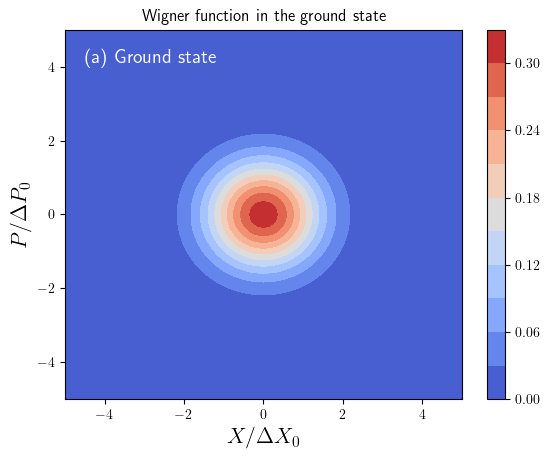

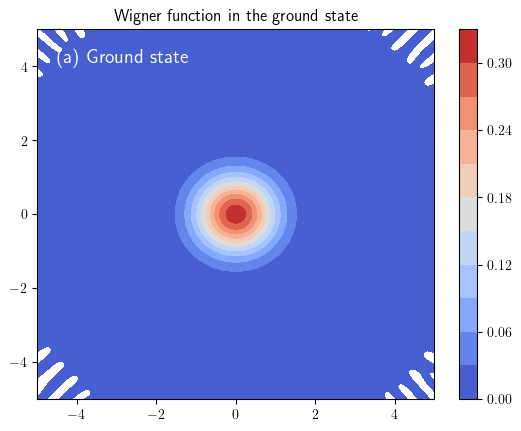

In [14]:
X_reduced = X[np.abs(X) < X_m_plot]
K_reduced = K[np.abs(K) < K_m_plot]

# W_ground_reduced = W_ground[]

# Find the indices where X and K are below their respective thresholds
X_indices = np.where(np.abs(X) < X_m_plot)[0]
K_indices = np.where(np.abs(K) < K_m_plot)[0]

# Create the reduced arrays
X_reduced = X[X_indices]
K_reduced = K[K_indices]

# Create the reduced W array
W_ground_reduced = W_ground[np.ix_(X_indices, K_indices)]

# Print the results
print(integrate_2d(X_reduced,K_reduced,W_ground_reduced)) # to check if W is normalised or not
# print("X_reduced:", X_reduced)
# print("K_reduced:", K_reduced)
# print("W_reduced:\n", W_ground_reduced)

Xm_reduced, Km_reduced = np.meshgrid(X_reduced, K_reduced)
fig,ax=plt.subplots(1,1)
cp = ax.contourf(Xm_reduced/sigma_wavefunction_ground,Km_reduced/sigma_k_ground,W_ground_reduced, 10,cmap = cm.coolwarm)
fig.colorbar(cp) # Add a colorbar to a plot
# cp1 = ax.contour(Xm/sigma_wavefunction_ground,Km/sigma_k_ground,W_ground,5, extend = 'min',cmap = 'Reds')
ax.set_title('Wigner function in the ground state')
ax.text(0.05, 0.95, '(a) Ground state', transform=ax.transAxes, fontsize=14, verticalalignment='top', color = 'white')
ax.set_xlabel('$X/\Delta X_{0}$', fontsize = 16)
ax.set_ylabel('$P/\Delta P_{0}$', fontsize = 16)
plt.xlim(-5,5)
plt.ylim(-5,5)
# plt.savefig('Wigner function in the ground state.pdf')
# plt.xlim(-20,20)
# plt.ylim(-20,20)
plt.show()

fig,ax=plt.subplots(1,1)
cp = ax.contourf(Xm_reduced,Km_reduced,W_ground_reduced, 10,cmap = cm.coolwarm)
fig.colorbar(cp) # Add a colorbar to a plot
# cp1 = ax.contour(Xm/sigma_wavefunction_ground,Km/sigma_k_ground,W_ground,5, extend = 'min',cmap = 'Reds')
ax.set_title('Wigner function in the ground state')
ax.text(0.05, 0.95, '(a) Ground state', transform=ax.transAxes, fontsize=14, verticalalignment='top', color = 'white')
# ax.set_xlabel('$X/\Delta X_{0}$', fontsize = 16)
# ax.set_ylabel('$P/\Delta P_{0}$', fontsize = 16)
plt.xlim(-5,5)
plt.ylim(-5,5)
# plt.savefig('Wigner function in the ground state.pdf')
# plt.xlim(-20,20)
# plt.ylim(-20,20)
plt.show()


# """analytical expression for wigner fn of ground state"""
# fig,ax=plt.subplots(1,1)
# W_ground_reduced_analytical = (1/pi) * np.exp(-(Xm_reduced/2/sigma_wavefunction_ground)**2) * np.exp(-(2*sigma_wavefunction_ground*Km_reduced)**2)

# cp = ax.contourf(Xm_reduced/sigma_wavefunction_ground,Km_reduced/sigma_k_ground,W_ground_reduced_analytical, 100,cmap = cm.coolwarm)
# fig.colorbar(cp) # Add a colorbar to a plot
# # cp1 = ax.contour(Xm/sigma_wavefunction_ground,Km/sigma_k_ground,W_ground,5, extend = 'min',cmap = 'Reds')
# # ax.set_title('Wigner function in the ground state')
# # ax.text(0.05, 0.95, '(a) Ground state', transform=ax.transAxes, fontsize=14, verticalalignment='top', color = 'white')
# ax.set_xlabel('$X/\Delta X_{0}$', fontsize = 16)
# ax.set_ylabel('$P/\Delta P_{0}$', fontsize = 16)
# plt.xlim(-5,5)
# plt.ylim(-5,5)
# # plt.savefig('Wigner function in the ground state.pdf')
# # plt.xlim(-20,20)
# # plt.ylim(-20,20)
# plt.show()




In [16]:
color_orange = (245/256,163/256,79/256) #orange
color_blue = (1/256,70/256,233/256) #blue
color_green = (12/256,164/256,12/256) #green
color_light_green = (12/256,164/256,12/256) #green
color_pink = (225/256,109/256,114/256) #light red-pink mix
color_light_pink = (240/256, 182/256, 185/256)

color_red = (217/256,10/256,11/256)
# print(color_pink)

______
______
______
______
______
______
Saving plot now...


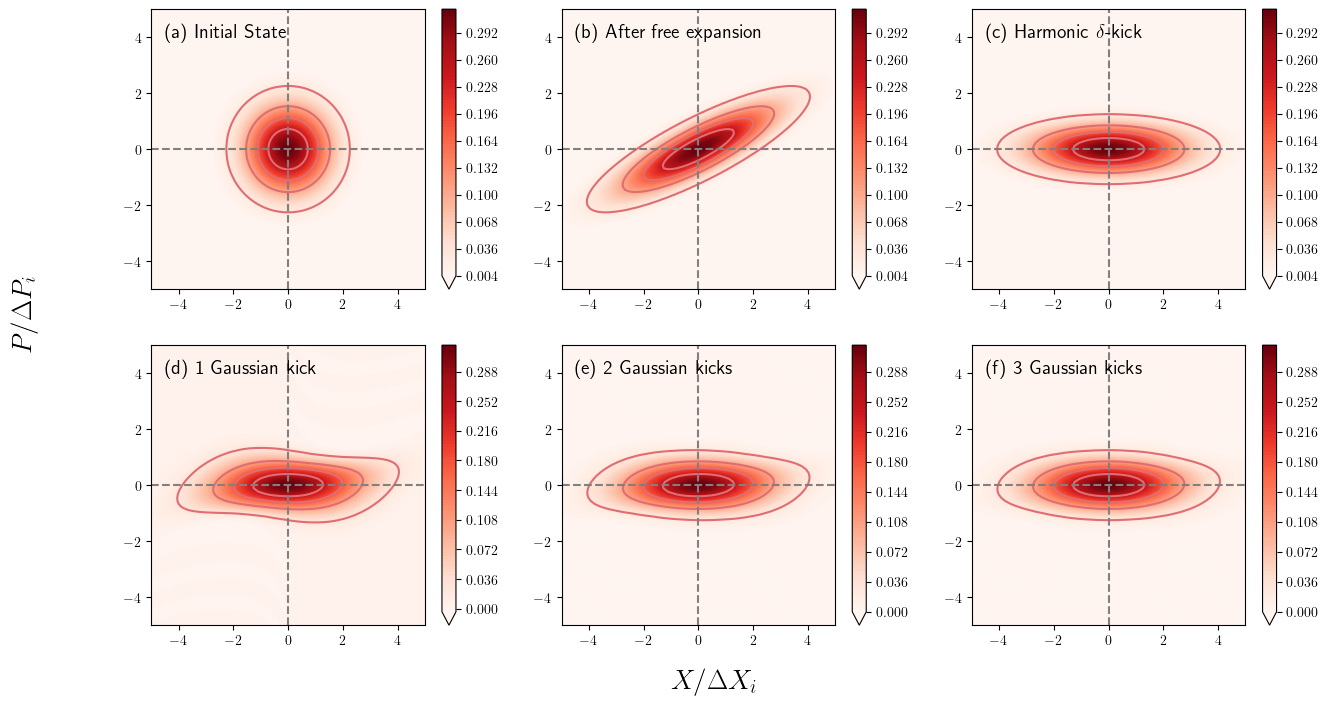

1500
[5. 4. 3.]


In [17]:
"""All the graphs in one place"""

"""plotting ground state, free expansion, Harmonic kick, 1 2 and 3 Gaussian kick"""

"""Same as above, but with different color bars for all"""

fig, ax = plt.subplots(2, 3, figsize=(15, 8))  # Adjust the figsize as per your requirement

CMAP_contourf = 'Reds'

cp0 = ax[0, 0].contourf(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_ground, 100, extend ='min', cmap = CMAP_contourf)
print("______")

cp1 = ax[0, 1].contourf(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_free_evolution, 100, extend ='min', cmap = CMAP_contourf)
print("______")

cp2 = ax[0, 2].contourf(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_harmonic_kick, 100, extend ='min', cmap = CMAP_contourf)
print("______")

cp3 = ax[1, 0].contourf(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_opt_Gaussian_kick, 100, extend ='min', cmap = CMAP_contourf)
print("______")

cp4 = ax[1, 1].contourf(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_2_delta_kick, 100, extend ='min', cmap = CMAP_contourf)
print("______")

cp5 = ax[1, 2].contourf(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_3_delta_kick, 100, extend ='min', cmap = CMAP_contourf)
print("______")


contour_levels = np.linspace(0.025,np.max(W_ground),5)
# CMAP_contour = CMAP_contourf
CMAP_contour = 'gist_gray'
color_contour = color_pink

# cp00 = ax[0, 0].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_ground, levels = contour_levels, extend = 'min', cmap = 'Reds')
# cp11 = ax[0, 1].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_free_evolution, levels = contour_levels, extend = 'min', cmap = 'Reds')
# cp22 = ax[0, 2].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_harmonic_kick, levels = contour_levels, extend = 'min', cmap = 'Reds')
# cp33 = ax[1, 0].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_opt_Gaussian_kick, levels = contour_levels, extend = 'min', cmap = 'Reds')
# cp44 = ax[1, 1].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_2_delta_kick, levels = contour_levels, extend = 'min', cmap = 'Reds')
# cp55 = ax[1, 2].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_3_delta_kick, levels = contour_levels, extend = 'min', cmap = 'Reds')

# cp00 = ax[0, 0].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_ground, levels = contour_levels, extend = 'min', cmap = CMAP_contour)
# cp11 = ax[0, 1].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_free_evolution, levels = contour_levels, extend = 'min', cmap = CMAP_contour)
# cp22 = ax[0, 2].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_harmonic_kick, levels = contour_levels, extend = 'min', cmap = CMAP_contour)
# cp33 = ax[1, 0].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_opt_Gaussian_kick, levels = contour_levels, extend = 'min', cmap = CMAP_contour)
# cp44 = ax[1, 1].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_2_delta_kick, levels = contour_levels, extend = 'min', cmap = CMAP_contour)
# cp55 = ax[1, 2].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_3_delta_kick, levels = contour_levels, extend = 'min', cmap = CMAP_contour)



cp00 = ax[0, 0].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_ground, levels = contour_levels, extend = 'min', colors = [color_contour])
cp11 = ax[0, 1].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_free_evolution, levels = contour_levels, extend = 'min', colors = [color_contour])
cp22 = ax[0, 2].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_harmonic_kick, levels = contour_levels, extend = 'min', colors = [color_contour])
cp33 = ax[1, 0].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_opt_Gaussian_kick, levels = contour_levels, extend = 'min', colors = [color_contour])
cp44 = ax[1, 1].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_2_delta_kick, levels = contour_levels, extend = 'min', colors = [color_contour])
cp55 = ax[1, 2].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_3_delta_kick, levels = contour_levels, extend = 'min', colors = [color_contour])



# cp00 = ax[0, 0].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_ground, 3, cmap = 'Reds')
# cp11 = ax[0, 1].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_free_evolution, 3, cmap = 'Reds')
# cp22 = ax[0, 2].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_harmonic_kick, 3, cmap = 'Reds')
# cp33 = ax[1, 0].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_opt_Gaussian_kick, 3, cmap = 'Reds')
# cp44 = ax[1, 1].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_2_delta_kick, 3, cmap = 'Reds')
# cp55 = ax[1, 2].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_3_delta_kick, 3, cmap = 'Reds')



# ax[0, 0].grid(linestyle = '--')
# ax[0, 1].grid(linestyle = '--')
# ax[0, 2].grid(linestyle = '--')
# ax[1, 0].grid(linestyle = '--')
# ax[1, 1].grid(linestyle = '--')
# ax[1, 2].grid(linestyle = '--')

ax[0, 0].axhline(y=0, color='grey', linestyle='--') # x axis
ax[0, 1].axhline(y=0, color='grey', linestyle='--') # x axis
ax[0, 2].axhline(y=0, color='grey', linestyle='--') # x axis
ax[1, 0].axhline(y=0, color='grey', linestyle='--') # x axis
ax[1, 1].axhline(y=0, color='grey', linestyle='--') # x axis
ax[1, 2].axhline(y=0, color='grey', linestyle='--') # x axis
ax[0, 0].axvline(x=0, color='grey', linestyle='--') # y axis
ax[0, 1].axvline(x=0, color='grey', linestyle='--') # y axis
ax[0, 2].axvline(x=0, color='grey', linestyle='--') # y axis
ax[1, 0].axvline(x=0, color='grey', linestyle='--') # y axis
ax[1, 1].axvline(x=0, color='grey', linestyle='--') # y axis
ax[1, 2].axvline(x=0, color='grey', linestyle='--') # y axis



ax[0, 0].text(0.05, 0.95, '(a) Initial State', transform=ax[0, 0].transAxes, fontsize=14, verticalalignment='top')
ax[0, 1].text(0.05, 0.95, '(b) After free expansion', transform=ax[0, 1].transAxes, fontsize=14, verticalalignment='top')
ax[0, 2].text(0.05, 0.95, '(c) Harmonic $\delta$-kick', transform=ax[0, 2].transAxes, fontsize=14, verticalalignment='top')
ax[1, 0].text(0.05, 0.95, '(d) 1 Gaussian kick', transform=ax[1, 0].transAxes, fontsize=14, verticalalignment='top')
ax[1, 1].text(0.05, 0.95, '(e) 2 Gaussian kicks', transform=ax[1, 1].transAxes, fontsize=14, verticalalignment='top')
ax[1, 2].text(0.05, 0.95, '(f) 3 Gaussian kicks', transform=ax[1, 2].transAxes, fontsize=14, verticalalignment='top')


# Add common xlabel and ylabel
fig.text(0.5, 0.04, '$X/\Delta X_{i}$', ha='center', va='center', fontsize=20)
fig.text(0.04, 0.5, '$P/\Delta P_{i}$', ha='center', va='center', rotation='vertical', fontsize=20)

# Add separate colorbar for all
fig.colorbar(cp0, ax=ax[0, 0])  # Add a colorbar to a plot
fig.colorbar(cp1, ax=ax[0, 1])  # Add a colorbar to a plot
fig.colorbar(cp2, ax=ax[0, 2])  # Add a colorbar to a plot
fig.colorbar(cp3, ax=ax[1, 0])  # Add a colorbar to a plot
fig.colorbar(cp4, ax=ax[1, 1])  # Add a colorbar to a plot
fig.colorbar(cp5, ax=ax[1, 2])  # Add a colorbar to a plot

X_m_plot = 5
K_m_plot = 5

ax[0, 0].set_xlim(-X_m_plot, X_m_plot)
ax[0, 0].set_ylim(-K_m_plot, K_m_plot)
ax[0, 1].set_xlim(-X_m_plot, X_m_plot)
ax[0, 1].set_ylim(-K_m_plot, K_m_plot)
ax[0, 2].set_xlim(-X_m_plot, X_m_plot)
ax[0, 2].set_ylim(-K_m_plot, K_m_plot)
ax[1, 0].set_xlim(-X_m_plot, X_m_plot)
ax[1, 0].set_ylim(-K_m_plot, K_m_plot)
ax[1, 1].set_xlim(-X_m_plot, X_m_plot)
ax[1, 1].set_ylim(-K_m_plot, K_m_plot)
ax[1, 2].set_xlim(-X_m_plot, X_m_plot)
ax[1, 2].set_ylim(-K_m_plot, K_m_plot)
# plt.tight_layout()

print("Saving plot now...")
# plt.savefig("Wigner fn - initial, free expansion for T_f = %5.3f, harmonic DKC, 1, 2 and 3 Gaussian DKC.pdf"%tuple([N_f*k]))
# plt.savefig("Wigner fn - initial, free expansion for T_f = %5.3f by omega_0, harmonic DKC, 1, 2 and 3 Gaussian DKC, sigma_array = (%5.1f,%5.1f,%5.1f)sigma_x_ground.png"%tuple([N_f*k,sigma_array[0]/sigma_wavefunction_ground,sigma_array[1]/sigma_wavefunction_ground,sigma_array[2]/sigma_wavefunction_ground]), dpi = 300)

# Define filename
filename = "Wigner fn - initial, free expansion for T_f = %5.3f by omega_0, harmonic DKC, 1, 2 and 3 Gaussian DKC, sigma_array = (%5.1f,%5.1f,%5.1f)sigma_x_ground.png"%tuple([N_f*k,sigma_array[0]/sigma_wavefunction_ground,sigma_array[1]/sigma_wavefunction_ground,sigma_array[2]/sigma_wavefunction_ground])
save_path = os.path.join(directory, filename)
# Save the plot
# plt.savefig(save_path, dpi=300)


plt.show()

print(N_f)
print(sigma_array/sigma_wavefunction_ground)


KeyboardInterrupt: 

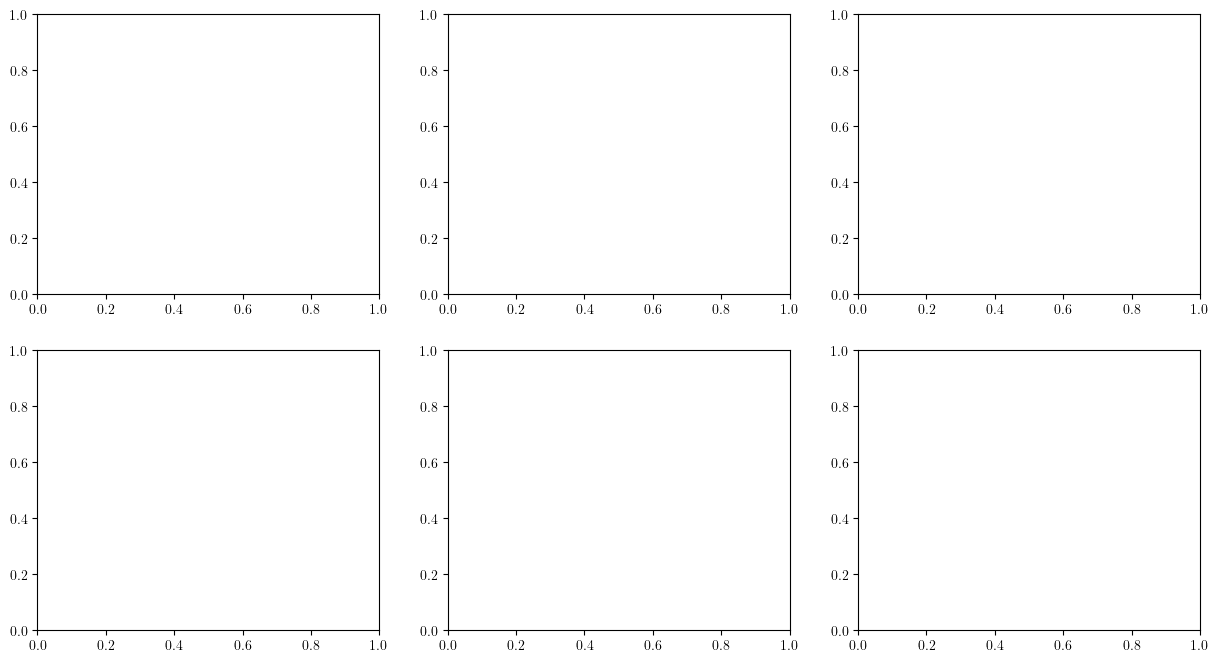

In [17]:
"""
Same as above, but with same color bar for all the plots

"""

fig, ax = plt.subplots(2, 3, figsize=(15, 8))  # Adjust the figsize as per your requirement

CMAP_contourf = 'Reds'

# Find the minimum and maximum values among all the 2D arrays
vmin1 = min(np.min(W_ground), np.min(W_after_free_evolution), np.min(W_after_harmonic_kick), 
           np.min(W_after_opt_Gaussian_kick), np.min(W_after_2_delta_kick), np.min(W_after_3_delta_kick))
vmax1 = max(np.max(W_ground), np.max(W_after_free_evolution), np.max(W_after_harmonic_kick), 
           np.max(W_after_opt_Gaussian_kick), np.max(W_after_2_delta_kick), np.max(W_after_3_delta_kick))

levels1 = np.linspace(vmin1, vmax1, 200)  # evenly spaced levels

cp0 = ax[0, 0].contourf(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_ground, levels=levels1, vmin=vmin1, vmax=vmax1, cmap = CMAP_contourf)
print("______")

cp1 = ax[0, 1].contourf(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_free_evolution, levels=levels1, vmin=vmin1, vmax=vmax1, cmap = CMAP_contourf)
print("______")

cp2 = ax[0, 2].contourf(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_harmonic_kick, levels=levels1, vmin=vmin1, vmax=vmax1, cmap = CMAP_contourf)
print("______")

cp3 = ax[1, 0].contourf(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_opt_Gaussian_kick, levels=levels1, vmin=vmin1, vmax=vmax1, cmap = CMAP_contourf)
print("______")

cp4 = ax[1, 1].contourf(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_2_delta_kick, levels=levels1, vmin=vmin1, vmax=vmax1, cmap = CMAP_contourf)
print("______")

cp5 = ax[1, 2].contourf(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_3_delta_kick, levels=levels1, vmin=vmin1, vmax=vmax1, cmap = CMAP_contourf)
print("______")

# Create a colormap and modify one specific level to be white
cmap = plt.get_cmap('Reds')
new_colors = cmap(np.linspace(0, 1, len(levels1)))

# Find the index of the level closest to 0
target_value = 0
target_idx = np.argmin(np.abs(levels1 - target_value))

# Set that level to white
new_colors[target_idx, :] = [1, 1, 1, 1]  # RGBA for white

custom_cmap = ListedColormap(new_colors)

norm = BoundaryNorm(levels1, len(levels1))














# Add a single colorbar for all plots
cbar = fig.colorbar(cp0, ax=ax.ravel().tolist(), orientation='vertical')
# Increase the size of the numbers on the colorbar
cbar.ax.tick_params(labelsize=15)


contour_levels = np.linspace(0.025,np.max(W_ground),5)
# CMAP_contour = CMAP_contourf
CMAP_contour = 'gist_gray'
color_contour = color_pink

# cp00 = ax[0, 0].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_ground, levels = contour_levels, extend = 'min', cmap = 'Reds')
# cp11 = ax[0, 1].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_free_evolution, levels = contour_levels, extend = 'min', cmap = 'Reds')
# cp22 = ax[0, 2].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_harmonic_kick, levels = contour_levels, extend = 'min', cmap = 'Reds')
# cp33 = ax[1, 0].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_opt_Gaussian_kick, levels = contour_levels, extend = 'min', cmap = 'Reds')
# cp44 = ax[1, 1].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_2_delta_kick, levels = contour_levels, extend = 'min', cmap = 'Reds')
# cp55 = ax[1, 2].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_3_delta_kick, levels = contour_levels, extend = 'min', cmap = 'Reds')

# cp00 = ax[0, 0].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_ground, levels = contour_levels, extend = 'min', cmap = CMAP_contour)
# cp11 = ax[0, 1].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_free_evolution, levels = contour_levels, extend = 'min', cmap = CMAP_contour)
# cp22 = ax[0, 2].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_harmonic_kick, levels = contour_levels, extend = 'min', cmap = CMAP_contour)
# cp33 = ax[1, 0].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_opt_Gaussian_kick, levels = contour_levels, extend = 'min', cmap = CMAP_contour)
# cp44 = ax[1, 1].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_2_delta_kick, levels = contour_levels, extend = 'min', cmap = CMAP_contour)
# cp55 = ax[1, 2].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_3_delta_kick, levels = contour_levels, extend = 'min', cmap = CMAP_contour)



cp00 = ax[0, 0].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_ground, levels = contour_levels,  colors = [color_contour])
cp11 = ax[0, 1].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_free_evolution, levels = contour_levels,  colors = [color_contour])
cp22 = ax[0, 2].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_harmonic_kick, levels = contour_levels,  colors = [color_contour])
cp33 = ax[1, 0].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_opt_Gaussian_kick, levels = contour_levels,  colors = [color_contour])
cp44 = ax[1, 1].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_2_delta_kick, levels = contour_levels,  colors = [color_contour])
cp55 = ax[1, 2].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_3_delta_kick, levels = contour_levels,  colors = [color_contour])



# cp00 = ax[0, 0].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_ground, 3, cmap = 'Reds')
# cp11 = ax[0, 1].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_free_evolution, 3, cmap = 'Reds')
# cp22 = ax[0, 2].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_harmonic_kick, 3, cmap = 'Reds')
# cp33 = ax[1, 0].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_opt_Gaussian_kick, 3, cmap = 'Reds')
# cp44 = ax[1, 1].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_2_delta_kick, 3, cmap = 'Reds')
# cp55 = ax[1, 2].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_3_delta_kick, 3, cmap = 'Reds')



# ax[0, 0].grid(linestyle = '--')
# ax[0, 1].grid(linestyle = '--')
# ax[0, 2].grid(linestyle = '--')
# ax[1, 0].grid(linestyle = '--')
# ax[1, 1].grid(linestyle = '--')
# ax[1, 2].grid(linestyle = '--')

ax[0, 0].axhline(y=0, color='grey', linestyle='--') # x axis
ax[0, 1].axhline(y=0, color='grey', linestyle='--') # x axis
ax[0, 2].axhline(y=0, color='grey', linestyle='--') # x axis
ax[1, 0].axhline(y=0, color='grey', linestyle='--') # x axis
ax[1, 1].axhline(y=0, color='grey', linestyle='--') # x axis
ax[1, 2].axhline(y=0, color='grey', linestyle='--') # x axis
ax[0, 0].axvline(x=0, color='grey', linestyle='--') # y axis
ax[0, 1].axvline(x=0, color='grey', linestyle='--') # y axis
ax[0, 2].axvline(x=0, color='grey', linestyle='--') # y axis
ax[1, 0].axvline(x=0, color='grey', linestyle='--') # y axis
ax[1, 1].axvline(x=0, color='grey', linestyle='--') # y axis
ax[1, 2].axvline(x=0, color='grey', linestyle='--') # y axis



pad = 2.9

ax[0, 0].text(0.05, 0.95, '(a) Initial State', transform=ax[0, 0].transAxes, fontsize=14, verticalalignment='top',  bbox=dict(facecolor=(1.0, 0.953, 0.933), alpha=1.0, edgecolor='none', pad=pad))
ax[0, 1].text(0.05, 0.95, '(b) After free expansion', transform=ax[0, 1].transAxes, fontsize=14, verticalalignment='top',  bbox=dict(facecolor=(1.0, 0.953, 0.933), alpha=1.0, edgecolor='none', pad=pad))
ax[0, 2].text(0.05, 0.95, '(c) Harmonic kick', transform=ax[0, 2].transAxes, fontsize=14, verticalalignment='top',  bbox=dict(facecolor=(1.0, 0.953, 0.933), alpha=1.0, edgecolor='none', pad=pad))
ax[1, 0].text(0.05, 0.95, '(d) 1 Gaussian kick', transform=ax[1, 0].transAxes, fontsize=14, verticalalignment='top',  bbox=dict(facecolor=(1.0, 0.953, 0.933), alpha=1.0, edgecolor='none', pad=pad))
ax[1, 1].text(0.05, 0.95, '(e) 2 Gaussian kicks', transform=ax[1, 1].transAxes, fontsize=14, verticalalignment='top',  bbox=dict(facecolor=(1.0, 0.953, 0.933), alpha=1.0, edgecolor='none', pad=pad))
ax[1, 2].text(0.05, 0.95, '(f) 3 Gaussian kicks', transform=ax[1, 2].transAxes, fontsize=14, verticalalignment='top',  bbox=dict(facecolor=(1.0, 0.953, 0.933), alpha=1.0, edgecolor='none', pad=pad))


# Add common xlabel and ylabel
# fig.text(0.5, 0.04, '$X/\Delta X_{i}$', ha='center', va='center', fontsize=20)
# fig.text(0.04, 0.5, '$P/\Delta P_{i}$', ha='center', va='center', rotation='vertical', fontsize=20)
fig.text(0.5, 0.04, '$x/\Delta x_{i}$', ha='center', va='center', fontsize=20)
fig.text(0.04, 0.5, '$p/\Delta p_{i}$', ha='center', va='center', rotation='vertical', fontsize=20)
# fig.supxlabel('$X/\Delta X_{i}$', fontsize=16)
# fig.supylabel('$P/\Delta P_{i}$', fontsize=16)





# Add separate colorbar for all
# fig.colorbar(cp0, ax=ax[0, 0])  # Add a colorbar to a plot
# fig.colorbar(cp1, ax=ax[0, 1])  # Add a colorbar to a plot
# fig.colorbar(cp2, ax=ax[0, 2])  # Add a colorbar to a plot
# fig.colorbar(cp3, ax=ax[1, 0])  # Add a colorbar to a plot
# fig.colorbar(cp4, ax=ax[1, 1])  # Add a colorbar to a plot
# fig.colorbar(cp5, ax=ax[1, 2])  # Add a colorbar to a plot

X_m_plot = 5
K_m_plot = 5

ax[0, 0].set_xlim(-X_m_plot, X_m_plot)
ax[0, 0].set_ylim(-K_m_plot, K_m_plot)
ax[0, 1].set_xlim(-X_m_plot, X_m_plot)
ax[0, 1].set_ylim(-K_m_plot, K_m_plot)
ax[0, 2].set_xlim(-X_m_plot, X_m_plot)
ax[0, 2].set_ylim(-K_m_plot, K_m_plot)
ax[1, 0].set_xlim(-X_m_plot, X_m_plot)
ax[1, 0].set_ylim(-K_m_plot, K_m_plot)
ax[1, 1].set_xlim(-X_m_plot, X_m_plot)
ax[1, 1].set_ylim(-K_m_plot, K_m_plot)
ax[1, 2].set_xlim(-X_m_plot, X_m_plot)
ax[1, 2].set_ylim(-K_m_plot, K_m_plot)
# plt.tight_layout()

print("Saving plot now...")
# plt.savefig("Wigner fn - initial, free expansion for T_f = %5.3f, harmonic DKC, 1, 2 and 3 Gaussian DKC.pdf"%tuple([N_f*k]))
# plt.savefig("Wigner fn - initial, free expansion for T_f = %5.3f by omega_0, harmonic DKC, 1, 2 and 3 Gaussian DKC, sigma_array = (%5.1f,%5.1f,%5.1f)sigma_x_ground.png"%tuple([N_f*k,sigma_array[0]/sigma_wavefunction_ground,sigma_array[1]/sigma_wavefunction_ground,sigma_array[2]/sigma_wavefunction_ground]), dpi = 300)

# Define filename
filename = "Wigner fn - initial, free expansion for T_f = %5.3f by omega_0, harmonic DKC, 1, 2 and 3 Gaussian DKC, sigma_array = (%5.1f,%5.1f,%5.1f)sigma_x_ground.png"%tuple([N_f*k,sigma_array[0]/sigma_wavefunction_ground,sigma_array[1]/sigma_wavefunction_ground,sigma_array[2]/sigma_wavefunction_ground])
save_path = os.path.join(directory, filename)
# Save the plot
# plt.savefig(save_path, dpi=300)


plt.show()

print(N_f)
print(sigma_array/sigma_wavefunction_ground)



[5. 4.]
W_2_Gaussian_DKC calculated______________
_____________________________
[5. 4. 3.]
W_3_Gaussian_DKC calculated______________
_____________________________
______
______
______
______
______
______
Saving plot now...


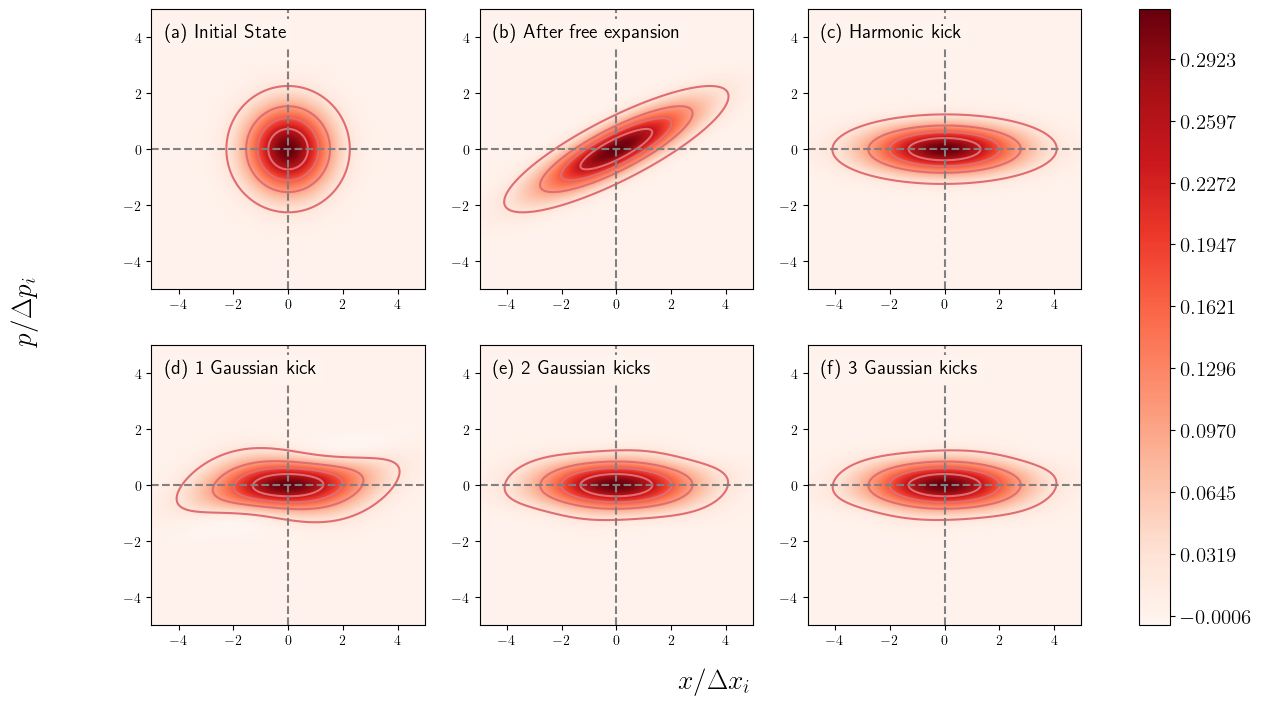

1500
[5. 4. 3.]


In [19]:
"""
Same as above, same color bar for all the plots.

Here, the Wigner function after 2 and 3 kick cases are calculated for kick parameters optimized numerically.

"""


"""2 Gaussian kick case"""

N_delta = 2 # number of delta kicks

kappa = np.zeros(N_delta)
B = np.zeros(N_delta)
A = np.zeros([N_delta,N_delta])
# equation is A*kappa = B
sigma_array = np.zeros(N_delta) # the matrix of the sigma (RMS size) of all the Gaussian beams
sigma_array[0] = sigma_a/sigma_wavefunction_ground # size of the first Gaussian lens beam, relative to the ground state wavefunction size
for i in range(N_delta):
    if i>0:
        sigma_array[i] = sigma_array[i-1]-1 # making all the beams differ in size by a fixed amount
sigma_array = sigma_array*sigma_wavefunction_ground
print(sigma_array/sigma_wavefunction_ground)

kappa = np.array([ 21.39830041, -10.17480476])
psi_after_2_delta_kick_numerical = psi_after_free_evolution*np.exp(-1j*kappa[0]*(1-np.exp(-0.5*(X**2)/(sigma_array[0]**2)))) # this is the first delta kick
psi_after_2_delta_kick_numerical = psi_after_2_delta_kick_numerical*np.exp(-1j*kappa[1]*(1-np.exp(-0.5*(X**2)/(sigma_array[1]**2))))
W_after_2_delta_kick_numerical = Wigner_fn(X,K,psi_after_2_delta_kick_numerical)

print("W_2_Gaussian_DKC calculated______________")
print("_____________________________")


"""Now 3 Gaussian kick case"""

N_delta = 3 # number of delta kicks

kappa = np.zeros(N_delta)
B = np.zeros(N_delta)
A = np.zeros([N_delta,N_delta])
# equation is A*kappa = B
sigma_array = np.zeros(N_delta) # the matrix of the sigma (RMS size) of all the Gaussian beams
sigma_array[0] = sigma_a/sigma_wavefunction_ground # size of the first Gaussian lens beam, relative to the ground state wavefunction size
for i in range(N_delta):
    if i>0:
        sigma_array[i] = sigma_array[i-1]-1 # making all the beams differ in size by a fixed amount
sigma_array = sigma_array*sigma_wavefunction_ground
print(sigma_array/sigma_wavefunction_ground)

kappa = np.array([27.13677432, -16.4082653, 1.47783357])
psi_after_3_delta_kick_numerical = psi_after_free_evolution*np.exp(-1j*kappa[0]*(1-np.exp(-0.5*(X**2)/(sigma_array[0]**2)))) # this is the first delta kick
psi_after_3_delta_kick_numerical = psi_after_3_delta_kick_numerical*np.exp(-1j*kappa[1]*(1-np.exp(-0.5*(X**2)/(sigma_array[1]**2)))) # 2nd delta kick
psi_after_3_delta_kick_numerical = psi_after_3_delta_kick_numerical*np.exp(-1j*kappa[2]*(1-np.exp(-0.5*(X**2)/(sigma_array[2]**2)))) # 3rd delta kick

W_after_3_delta_kick_numerical = Wigner_fn(X,K,psi_after_3_delta_kick_numerical)

print("W_3_Gaussian_DKC calculated______________")
print("_____________________________")




fig, ax = plt.subplots(2, 3, figsize=(15, 8))  # Adjust the figsize as per your requirement

CMAP_contourf = 'Reds'

# Find the minimum and maximum values among all the 2D arrays
vmin1 = min(np.min(W_ground), np.min(W_after_free_evolution), np.min(W_after_harmonic_kick), 
           np.min(W_after_opt_Gaussian_kick), np.min(W_after_2_delta_kick_numerical), np.min(W_after_3_delta_kick_numerical))
vmax1 = max(np.max(W_ground), np.max(W_after_free_evolution), np.max(W_after_harmonic_kick), 
           np.max(W_after_opt_Gaussian_kick), np.max(W_after_2_delta_kick_numerical), np.max(W_after_3_delta_kick_numerical))

levels1 = np.linspace(vmin1, vmax1, 200)  # evenly spaced levels

cp0 = ax[0, 0].contourf(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_ground, levels=levels1, vmin=vmin1, vmax=vmax1, cmap = CMAP_contourf)
print("______")

cp1 = ax[0, 1].contourf(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_free_evolution, levels=levels1, vmin=vmin1, vmax=vmax1, cmap = CMAP_contourf)
print("______")

cp2 = ax[0, 2].contourf(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_harmonic_kick, levels=levels1, vmin=vmin1, vmax=vmax1, cmap = CMAP_contourf)
print("______")

cp3 = ax[1, 0].contourf(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_opt_Gaussian_kick, levels=levels1, vmin=vmin1, vmax=vmax1, cmap = CMAP_contourf)
print("______")

cp4 = ax[1, 1].contourf(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_2_delta_kick_numerical, levels=levels1, vmin=vmin1, vmax=vmax1, cmap = CMAP_contourf)
print("______")

cp5 = ax[1, 2].contourf(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_3_delta_kick_numerical, levels=levels1, vmin=vmin1, vmax=vmax1, cmap = CMAP_contourf)
print("______")

# Create a colormap and modify one specific level to be white
cmap = plt.get_cmap('Reds')
new_colors = cmap(np.linspace(0, 1, len(levels1)))

# Find the index of the level closest to 0
target_value = 0
target_idx = np.argmin(np.abs(levels1 - target_value))

# Set that level to white
new_colors[target_idx, :] = [1, 1, 1, 1]  # RGBA for white

custom_cmap = ListedColormap(new_colors)

norm = BoundaryNorm(levels1, len(levels1))














# Add a single colorbar for all plots
cbar = fig.colorbar(cp0, ax=ax.ravel().tolist(), orientation='vertical')
# Increase the size of the numbers on the colorbar
cbar.ax.tick_params(labelsize=15)


contour_levels = np.linspace(0.025,np.max(W_ground),5)
# CMAP_contour = CMAP_contourf
CMAP_contour = 'gist_gray'
color_contour = color_pink

# cp00 = ax[0, 0].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_ground, levels = contour_levels, extend = 'min', cmap = 'Reds')
# cp11 = ax[0, 1].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_free_evolution, levels = contour_levels, extend = 'min', cmap = 'Reds')
# cp22 = ax[0, 2].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_harmonic_kick, levels = contour_levels, extend = 'min', cmap = 'Reds')
# cp33 = ax[1, 0].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_opt_Gaussian_kick, levels = contour_levels, extend = 'min', cmap = 'Reds')
# cp44 = ax[1, 1].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_2_delta_kick, levels = contour_levels, extend = 'min', cmap = 'Reds')
# cp55 = ax[1, 2].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_3_delta_kick, levels = contour_levels, extend = 'min', cmap = 'Reds')

# cp00 = ax[0, 0].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_ground, levels = contour_levels, extend = 'min', cmap = CMAP_contour)
# cp11 = ax[0, 1].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_free_evolution, levels = contour_levels, extend = 'min', cmap = CMAP_contour)
# cp22 = ax[0, 2].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_harmonic_kick, levels = contour_levels, extend = 'min', cmap = CMAP_contour)
# cp33 = ax[1, 0].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_opt_Gaussian_kick, levels = contour_levels, extend = 'min', cmap = CMAP_contour)
# cp44 = ax[1, 1].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_2_delta_kick, levels = contour_levels, extend = 'min', cmap = CMAP_contour)
# cp55 = ax[1, 2].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_3_delta_kick, levels = contour_levels, extend = 'min', cmap = CMAP_contour)



cp00 = ax[0, 0].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_ground, levels = contour_levels,  colors = [color_contour])
cp11 = ax[0, 1].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_free_evolution, levels = contour_levels,  colors = [color_contour])
cp22 = ax[0, 2].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_harmonic_kick, levels = contour_levels,  colors = [color_contour])
cp33 = ax[1, 0].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_opt_Gaussian_kick, levels = contour_levels,  colors = [color_contour])
cp44 = ax[1, 1].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_2_delta_kick_numerical, levels = contour_levels,  colors = [color_contour])
cp55 = ax[1, 2].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_3_delta_kick_numerical, levels = contour_levels,  colors = [color_contour])



# cp00 = ax[0, 0].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_ground, 3, cmap = 'Reds')
# cp11 = ax[0, 1].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_free_evolution, 3, cmap = 'Reds')
# cp22 = ax[0, 2].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_harmonic_kick, 3, cmap = 'Reds')
# cp33 = ax[1, 0].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_opt_Gaussian_kick, 3, cmap = 'Reds')
# cp44 = ax[1, 1].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_2_delta_kick, 3, cmap = 'Reds')
# cp55 = ax[1, 2].contour(Xm/sigma_wavefunction_ground, Km/sigma_k_ground, W_after_3_delta_kick, 3, cmap = 'Reds')



# ax[0, 0].grid(linestyle = '--')
# ax[0, 1].grid(linestyle = '--')
# ax[0, 2].grid(linestyle = '--')
# ax[1, 0].grid(linestyle = '--')
# ax[1, 1].grid(linestyle = '--')
# ax[1, 2].grid(linestyle = '--')

ax[0, 0].axhline(y=0, color='grey', linestyle='--') # x axis
ax[0, 1].axhline(y=0, color='grey', linestyle='--') # x axis
ax[0, 2].axhline(y=0, color='grey', linestyle='--') # x axis
ax[1, 0].axhline(y=0, color='grey', linestyle='--') # x axis
ax[1, 1].axhline(y=0, color='grey', linestyle='--') # x axis
ax[1, 2].axhline(y=0, color='grey', linestyle='--') # x axis
ax[0, 0].axvline(x=0, color='grey', linestyle='--') # y axis
ax[0, 1].axvline(x=0, color='grey', linestyle='--') # y axis
ax[0, 2].axvline(x=0, color='grey', linestyle='--') # y axis
ax[1, 0].axvline(x=0, color='grey', linestyle='--') # y axis
ax[1, 1].axvline(x=0, color='grey', linestyle='--') # y axis
ax[1, 2].axvline(x=0, color='grey', linestyle='--') # y axis



pad = 2.9

ax[0, 0].text(0.05, 0.95, '(a) Initial State', transform=ax[0, 0].transAxes, fontsize=14, verticalalignment='top',  bbox=dict(facecolor=(1.0, 0.953, 0.933), alpha=1.0, edgecolor='none', pad=pad))
ax[0, 1].text(0.05, 0.95, '(b) After free expansion', transform=ax[0, 1].transAxes, fontsize=14, verticalalignment='top',  bbox=dict(facecolor=(1.0, 0.953, 0.933), alpha=1.0, edgecolor='none', pad=pad))
ax[0, 2].text(0.05, 0.95, '(c) Harmonic kick', transform=ax[0, 2].transAxes, fontsize=14, verticalalignment='top',  bbox=dict(facecolor=(1.0, 0.953, 0.933), alpha=1.0, edgecolor='none', pad=pad))
ax[1, 0].text(0.05, 0.95, '(d) 1 Gaussian kick', transform=ax[1, 0].transAxes, fontsize=14, verticalalignment='top',  bbox=dict(facecolor=(1.0, 0.953, 0.933), alpha=1.0, edgecolor='none', pad=pad))
ax[1, 1].text(0.05, 0.95, '(e) 2 Gaussian kicks', transform=ax[1, 1].transAxes, fontsize=14, verticalalignment='top',  bbox=dict(facecolor=(1.0, 0.953, 0.933), alpha=1.0, edgecolor='none', pad=pad))
ax[1, 2].text(0.05, 0.95, '(f) 3 Gaussian kicks', transform=ax[1, 2].transAxes, fontsize=14, verticalalignment='top',  bbox=dict(facecolor=(1.0, 0.953, 0.933), alpha=1.0, edgecolor='none', pad=pad))


# Add common xlabel and ylabel
# fig.text(0.5, 0.04, '$X/\Delta X_{i}$', ha='center', va='center', fontsize=20)
# fig.text(0.04, 0.5, '$P/\Delta P_{i}$', ha='center', va='center', rotation='vertical', fontsize=20)
fig.text(0.5, 0.04, '$x/\Delta x_{i}$', ha='center', va='center', fontsize=20)
fig.text(0.04, 0.5, '$p/\Delta p_{i}$', ha='center', va='center', rotation='vertical', fontsize=20)
# fig.supxlabel('$X/\Delta X_{i}$', fontsize=16)
# fig.supylabel('$P/\Delta P_{i}$', fontsize=16)





# Add separate colorbar for all
# fig.colorbar(cp0, ax=ax[0, 0])  # Add a colorbar to a plot
# fig.colorbar(cp1, ax=ax[0, 1])  # Add a colorbar to a plot
# fig.colorbar(cp2, ax=ax[0, 2])  # Add a colorbar to a plot
# fig.colorbar(cp3, ax=ax[1, 0])  # Add a colorbar to a plot
# fig.colorbar(cp4, ax=ax[1, 1])  # Add a colorbar to a plot
# fig.colorbar(cp5, ax=ax[1, 2])  # Add a colorbar to a plot

X_m_plot = 5
K_m_plot = 5

ax[0, 0].set_xlim(-X_m_plot, X_m_plot)
ax[0, 0].set_ylim(-K_m_plot, K_m_plot)
ax[0, 1].set_xlim(-X_m_plot, X_m_plot)
ax[0, 1].set_ylim(-K_m_plot, K_m_plot)
ax[0, 2].set_xlim(-X_m_plot, X_m_plot)
ax[0, 2].set_ylim(-K_m_plot, K_m_plot)
ax[1, 0].set_xlim(-X_m_plot, X_m_plot)
ax[1, 0].set_ylim(-K_m_plot, K_m_plot)
ax[1, 1].set_xlim(-X_m_plot, X_m_plot)
ax[1, 1].set_ylim(-K_m_plot, K_m_plot)
ax[1, 2].set_xlim(-X_m_plot, X_m_plot)
ax[1, 2].set_ylim(-K_m_plot, K_m_plot)
# plt.tight_layout()

print("Saving plot now...")
# plt.savefig("Wigner fn - initial, free expansion for T_f = %5.3f, harmonic DKC, 1, 2 and 3 Gaussian DKC.pdf"%tuple([N_f*k]))
# plt.savefig("Wigner fn - initial, free expansion for T_f = %5.3f by omega_0, harmonic DKC, 1, 2 and 3 Gaussian DKC, sigma_array = (%5.1f,%5.1f,%5.1f)sigma_x_ground.png"%tuple([N_f*k,sigma_array[0]/sigma_wavefunction_ground,sigma_array[1]/sigma_wavefunction_ground,sigma_array[2]/sigma_wavefunction_ground]), dpi = 300)

# Define filename
filename = "Wigner fn - initial, free expansion for T_f = %5.3f by omega_0, harmonic DKC, 1, 2 and 3 Gaussian DKC, sigma_array = (%5.1f,%5.1f,%5.1f)sigma_x_ground.png"%tuple([N_f*k,sigma_array[0]/sigma_wavefunction_ground,sigma_array[1]/sigma_wavefunction_ground,sigma_array[2]/sigma_wavefunction_ground])
save_path = os.path.join(directory, filename)
# Save the plot
plt.savefig(save_path, dpi=300)


plt.show()

print(N_f)
print(sigma_array/sigma_wavefunction_ground)



In [40]:
print(vmin1)
print(vmax1)
print(levels1)

-0.005262462592576285
0.31830988618379125
[-0.00526246 -0.00363647 -0.00201048 -0.00038449  0.0012415   0.0028675
  0.00449349  0.00611948  0.00774547  0.00937146  0.01099745  0.01262345
  0.01424944  0.01587543  0.01750142  0.01912741  0.0207534   0.0223794
  0.02400539  0.02563138  0.02725737  0.02888336  0.03050935  0.03213535
  0.03376134  0.03538733  0.03701332  0.03863931  0.04026531  0.0418913
  0.04351729  0.04514328  0.04676927  0.04839526  0.05002126  0.05164725
  0.05327324  0.05489923  0.05652522  0.05815121  0.05977721  0.0614032
  0.06302919  0.06465518  0.06628117  0.06790716  0.06953316  0.07115915
  0.07278514  0.07441113  0.07603712  0.07766311  0.07928911  0.0809151
  0.08254109  0.08416708  0.08579307  0.08741906  0.08904506  0.09067105
  0.09229704  0.09392303  0.09554902  0.09717501  0.09880101  0.100427
  0.10205299  0.10367898  0.10530497  0.10693096  0.10855696  0.11018295
  0.11180894  0.11343493  0.11506092  0.11668692  0.11831291  0.1199389
  0.12156489  0.1